## 데이터 불러오기

In [214]:
def read_data(filename):

    with open(filename, "r", encoding="UTF8") as f:
        data = [line.split("\t") for line in f.read().splitlines()]

    return data

In [215]:
train_data = read_data("fci_train_val.txt")
X_train_data = [t[1] for t in train_data]
y_train_data = [int(t[0]) for t in train_data]

test_data = read_data("fci_test.txt")
X_test_data = [t[1] for t in test_data]
y_test_data = [int(t[0]) for t in test_data]

In [216]:
print("X_train_data:", len(X_train_data))
print("y_train_data:", len(y_train_data))
print("X_test_data:", len(X_test_data))
print("y_test_data:", len(y_test_data))

X_train_data: 55134
y_train_data: 55134
X_test_data: 6121
y_test_data: 6121


## 데이터 Augumentation
#### Easy Data Augmentation Techniques for Boosting Performance on Text Classification Tasks 논문 참고

SR: Synonym Replacement, 특정 단어를 유의어로 교체  
RI: Random Insertion, 임의의 단어를 삽입  
RS: Random Swap, 문장 내 임의의 두 단어의 위치를 바꿈  
RD: Random Deletion: 임의의 단어를 삭제 

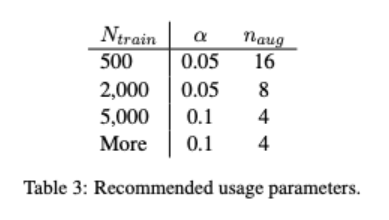

In [217]:
label = {}

for i in range(7):
    label[i]=y_train_data.count(i)

label

{0: 5409, 1: 16470, 2: 16083, 3: 11672, 4: 1571, 5: 979, 6: 2950}

In [218]:
import random
import pickle
import re

wordnet = {}
with open("wordnet.pickle", "rb") as f:
	wordnet = pickle.load(f)


# 한글만 남기고 나머지는 삭제
def get_only_hangul(line):
	parseText= re.compile('/ ^[ㄱ-ㅎㅏ-ㅣ가-힣]*$/').sub('',line)

	return parseText



########################################################################
# Synonym replacement
# Replace n words in the sentence with synonyms from wordnet
########################################################################
def synonym_replacement(words, n):
	new_words = words.copy()
	random_word_list = set([word for word in words])
	random_word_list = list(random_word_list)
	random.shuffle(random_word_list)
	num_replaced = 0
	for random_word in random_word_list:
		synonyms = get_synonyms(random_word)
		if len(synonyms) >= 1:
			synonym = random.choice(list(synonyms))
			new_words = [synonym if word == random_word else word for word in new_words]
			num_replaced += 1
		if num_replaced >= n:
			break

	if len(new_words) != 0:
		sentence = ' '.join(new_words)
		new_words = sentence.split(" ")

	else:
		new_words = ""

	return new_words


def get_synonyms(word):
	synomyms = []

	try:
		for syn in wordnet[word]:
			for s in syn:
				synomyms.append(s)
	except:
		pass

	return synomyms

########################################################################
# Random deletion
# Randomly delete words from the sentence with probability p
########################################################################
def random_deletion(words, p):
	if len(words) == 1:
		return words

	new_words = []
	for word in words:
		r = random.uniform(0, 1)
		if r > p:
			new_words.append(word)

	if len(new_words) == 0:
		rand_int = random.randint(0, len(words)-1)
		return [words[rand_int]]

	return new_words

########################################################################
# Random swap
# Randomly swap two words in the sentence n times
########################################################################
def random_swap(words, n):
	new_words = words.copy()
	for _ in range(n):
		new_words = swap_word(new_words)

	return new_words

def swap_word(new_words):
	random_idx_1 = random.randint(0, len(new_words)-1)
	random_idx_2 = random_idx_1
	counter = 0

	while random_idx_2 == random_idx_1:
		random_idx_2 = random.randint(0, len(new_words)-1)
		counter += 1
		if counter > 3:
			return new_words

	new_words[random_idx_1], new_words[random_idx_2] = new_words[random_idx_2], new_words[random_idx_1]
	return new_words

########################################################################
# Random insertion
# Randomly insert n words into the sentence
########################################################################
def random_insertion(words, n):
	new_words = words.copy()
	for _ in range(n):
		add_word(new_words)
	
	return new_words


def add_word(new_words):
	synonyms = []
	counter = 0
	while len(synonyms) < 1:
		if len(new_words) >= 1:
			random_word = new_words[random.randint(0, len(new_words)-1)]
			synonyms = get_synonyms(random_word)
			counter += 1
		else:
			random_word = ""

		if counter >= 10:
			return
		
	random_synonym = synonyms[0]
	random_idx = random.randint(0, len(new_words)-1)
	new_words.insert(random_idx, random_synonym)



def EDA(sentence, alpha_sr=0.1, alpha_ri=0.1, alpha_rs=0.1, p_rd=0.1, num_aug=4):
	sentence = get_only_hangul(sentence)
	words = sentence.split(' ')
	words = [word for word in words if word is not ""]
	num_words = len(words)

	augmented_sentences = []
	num_new_per_technique = int(num_aug/4) + 1

	n_sr = max(1, int(alpha_sr*num_words))
	n_ri = max(1, int(alpha_ri*num_words))
	n_rs = max(1, int(alpha_rs*num_words))

	# sr
	for _ in range(num_new_per_technique):
		a_words = synonym_replacement(words, n_sr)
		augmented_sentences.append(' '.join(a_words))

	# ri
	for _ in range(num_new_per_technique):
		a_words = random_insertion(words, n_ri)
		augmented_sentences.append(' '.join(a_words))

	# rs
	for _ in range(num_new_per_technique):
		a_words = random_swap(words, n_rs)
		augmented_sentences.append(" ".join(a_words))

	# rd
	for _ in range(num_new_per_technique):
		a_words = random_deletion(words, p_rd)
		augmented_sentences.append(" ".join(a_words))

	augmented_sentences = [get_only_hangul(sentence) for sentence in augmented_sentences]
	random.shuffle(augmented_sentences)

	if num_aug >= 1:
		augmented_sentences = augmented_sentences[:num_aug]
	else:
		keep_prob = num_aug / len(augmented_sentences)
		augmented_sentences = [s for s in augmented_sentences if random.uniform(0, 1) < keep_prob]

	augmented_sentences.append(sentence)

	return augmented_sentences

<>:139: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:139: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-218-c98ba5e1121c>:139: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  words = [word for word in words if word is not ""]


### 예시 문장

In [219]:
sentence = '나는 배가 고프다'
list_1 = EDA(sentence, alpha_sr=0.1, alpha_ri=0.1, alpha_rs=0.1, p_rd=0.1, num_aug=4)
list_1

['나는 가 고프다', '나는 배가 배 고프다', '나는 배가 고프다', '배가 고프다', '나는 배가 고프다']

### 라벨별로 데이터 수 차이 나는 것을 해결

In [220]:
# {0: 5409, 1: 16470, 2: 16083, 3: 11672, 4: 1571, 5: 979, 6: 2950}

for i in range(len(X_train_data)):
    if y_train_data[i] == 0:
        list_add = EDA(X_train_data[i], alpha_sr=0.1, alpha_ri=0.1, alpha_rs=0.1, p_rd=0.1, num_aug=2)
        for j in range((len(list_add)-1)):
            X_train_data.append(list_add[j])
            y_train_data.append(y_train_data[i])
            
#     elif y_train_data[i] == 1:
#         list_add = EDA(X_train_data[i], alpha_sr=0.1, alpha_ri=0.1, alpha_rs=0.1, p_rd=0.1, num_aug=4)
#         for j in range((len(list_add)-1)):
#             X_train_data.append(list_add[j])
#             y_train_data.append(y_train_data[i])
            
#     elif y_train_data[i] == 2:
#         list_add = EDA(X_train_data[i], alpha_sr=0.1, alpha_ri=0.1, alpha_rs=0.1, p_rd=0.1, num_aug=4)
#         for j in range((len(list_add)-1)):
#             X_train_data.append(list_add[j])
#             y_train_data.append(y_train_data[i])
            
#     elif y_train_data[i] == 3:
#         list_add = EDA(X_train_data[i], alpha_sr=0.1, alpha_ri=0.1, alpha_rs=0.1, p_rd=0.1, num_aug=4)
#         for j in range((len(list_add)-1)):
#             X_train_data.append(list_add[j])
#             y_train_data.append(y_train_data[i])
            
    elif y_train_data[i] == 4:
        list_add = EDA(X_train_data[i], alpha_sr=0.1, alpha_ri=0.1, alpha_rs=0.1, p_rd=0.1, num_aug=8)
        for j in range((len(list_add)-1)):
            X_train_data.append(list_add[j])
            y_train_data.append(y_train_data[i])
            
    elif y_train_data[i] == 5:
        list_add = EDA(X_train_data[i], alpha_sr=0.1, alpha_ri=0.1, alpha_rs=0.1, p_rd=0.1, num_aug=8)
        for j in range((len(list_add)-1)):
            X_train_data.append(list_add[j])
            y_train_data.append(y_train_data[i])
            
    elif y_train_data[i] == 6:
        list_add = EDA(X_train_data[i], alpha_sr=0.1, alpha_ri=0.1, alpha_rs=0.1, p_rd=0.1, num_aug=4)
        for j in range((len(list_add)-1)):
            X_train_data.append(list_add[j])
            y_train_data.append(y_train_data[i])


### Augumentation 결과

In [221]:
label = {}

for i in range(7):
    label[i]=y_train_data.count(i)

label

# 이전 값
# {0: 4285, 1: 13205, 2: 12911, 3: 9274, 4: 1248, 5: 795, 6: 2389}

{0: 16227, 1: 16470, 2: 16083, 3: 11672, 4: 14139, 5: 8811, 6: 14750}

In [222]:
total = 0

for i in label.values():
    total += i

print(total)

98152


#### augumentation 결과: 중복이 많아 보임 -> 4가지 방법론 중 일부만 사용해야하나

In [223]:
X_train_data[65134:65234]

['수경이 자식이 딴소리야 말을 했냐니까 왜 무슨',
 '수경이 자식이 무슨 말을 했냐니까 왜 딴소리야',
 '술김에 한 얘기였나',
 '술김에 한',
 '술김에 한 얘기였나',
 '술김에 한 얘기였나',
 '얘기였나 한 술김에',
 '한 술김에 얘기였나',
 '한 술김에 얘기였나',
 '술김에 한 얘기였나',
 '마흔여덟 웬',
 '웬 마흔여덟',
 '웬 마흔여덟',
 '마흔여덟 웬',
 '웬 마흔여덟',
 '웬 마흔여덟',
 '마흔여덟 웬',
 '웬 마흔여덟',
 '아빠 아빠 이게 뭔소리야',
 '아빠 이게 뭔소리야',
 '아빠 아빠 이게 뭔소리야',
 '아빠 아빠 이게 뭔소리야',
 '아빠 아빠 이게 뭔소리야',
 '아빠 아빠 이게 뭔소리야',
 '아빠 아빠 뭔소리야 이게',
 '아빠 아빠 이게 뭔소리야',
 '건강 식품들은 왜 이리 건 다 비싼 거지',
 '이리 식품들은 왜 건강 다 비싼 거지',
 '건강 식품들은 왜 이리 다 비싼 거지',
 '건강 식품들은 왜 이리 다 거 비싼 거지',
 '건강 식품들은 왜 이 다 비싼 거지',
 '건강 식품들은 왜 이 다 비싼 거지',
 '건강 식품들은 왜 건 이리 다 비싼 거지',
 '건강 식품들은 왜 이리 다 비싼 거지',
 '주식을 사고 팔 때 단위가 있는 것 때 알아',
 '주식을 사고 팔 때 단위가 것 알아',
 '주식을 사고 때 팔 단위가 있는 것 알아',
 '주식을 사고 팔 때 단위가 있는 것 알아',
 '팔 사고 주식을 때 단위가 있는 것 알아',
 '주식을 사고 팔 때 때 단위가 있는 것 알아',
 '주식을 사고 팔 때 단위가 있는 것 알아',
 '주식을 사고 팔 때 단위가 있는 것 알아',
 '뭐야 왜 이렇게 시끄러',
 '뭐야 왜 시끄러 이렇게',
 '왜 뭐야 이렇게 시끄러',
 '뭐야 왜 이렇게 시끄러',
 '뭐야 왜 이렇게 시끄러',
 '뭐야 왜 이렇게 시끄러',
 '뭐야 왜 이렇게 시끄러',
 '왜 뭐야 이렇게 시끄러',
 '외할머니 나 봐줄 때 내가 문제 있었어',
 '외할머니 나 봐줄 때

#### 실행 x (for 중복해결, y_train 값이 문제)
y_train_data 방법 생각이 안남_실행 x  
X_train_data_set = set(X_train_data)  
X_train_data = list(X_train_data_set)  
len(X_train_data)

### 토큰화 및 불용어 제거

In [153]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [224]:
import nltk
# nltk.download()

In [225]:
stopwords_wiki = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [226]:
import pandas as pd
# https://www.ranks.nl/stopwords/korean

df = pd.read_csv("stopwords.txt", names=['word'])
stopwords = df['word'].tolist()
stopwords.extend(stopwords_wiki)
print(stopwords[:10])

['아', '휴', '아이구', '아이쿠', '아이고', '어', '나', '우리', '저희', '따라']


##### 형태소 분석기 OKT를 사용한 토큰화 작업_문제 발생: 어간이 추출됨 (해결함)
from konlpy.tag import Okt  

okt = Okt()  
tokenized_data = []  
for sentence in X_train_data:  
    temp_X = okt.morphs(sentence, stem=True) # 토큰화  
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거  
    tokenized_data.append(temp_X)  

In [227]:
# 토큰화는 X_train_data, X_test_data 모두 같이 진행해야함

X_data = X_train_data + X_test_data
print(len(X_data))

104273


In [228]:
from konlpy.tag import Okt
pos_tagger = Okt()

tokenized_data = []
for sentence in X_data:
    temp_X = pos_tagger.morphs(sentence, stem=False) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    tokenized_data.append(temp_X)

In [229]:
X_data

['만화',
 '이치가',
 '약',
 '그사이',
 '짜긴',
 '혜택',
 '지출',
 '어젯밤',
 '승진',
 '꼬마',
 '신청',
 '엄마 꼭 꼭 ',
 '어어 그게',
 '브로셔 보여준다는 게',
 '김밥',
 '끝내',
 '대학',
 '손잡이',
 '참여',
 '군',
 '차차',
 '집안일',
 '내내 싸들고',
 '그냥',
 '구별',
 '시합',
 '글자',
 '비슷한',
 '의사',
 '그래',
 '여군',
 '골목',
 '경쟁력',
 '한층',
 '도대체',
 '희곡',
 '이러고',
 '없을',
 '반죽',
 '자리',
 '지금 도착',
 '볶음밥',
 '그거',
 '참석자',
 '젓가락',
 '소위',
 '부',
 '몇몇',
 '얘길',
 '너무',
 '발음',
 '또',
 '역',
 '아나운서',
 '북',
 '걸음',
 '단둘이',
 '햄',
 '의사',
 '실수',
 '치아',
 '개미',
 '뿌듯',
 '처음',
 '누구',
 '영화배우',
 '여친',
 '버터',
 '비참한',
 '우리가',
 '오로지',
 '절',
 '얘길',
 '실내',
 '단순히',
 '과제',
 '좌석',
 '여럿',
 '주변',
 '한번',
 '뭐야 그거',
 '나쁜 눔이 ',
 '최소한',
 '형수',
 '방면',
 '영역',
 '암',
 '종',
 '그만',
 '국제선',
 '안녕',
 '과외',
 '담',
 '유리창',
 '퇴직금',
 '위아래',
 '과자',
 '아까',
 '여기',
 '금메달',
 '그래요 거기',
 '자',
 '도입',
 '거면',
 '갇혀서 살 순',
 '존재',
 '잠자리',
 '싸움',
 '자전거',
 '답답해',
 '용돈도',
 '연장',
 '올해',
 '품속이었고 ',
 '해석',
 '방향',
 '크기',
 '텅',
 '흉내',
 '사이에서',
 '참석',
 '성함',
 '공식',
 '사이즈',
 '목요일',
 '뭐가',
 '같은',
 '조명',
 '어쩌다',
 '차량',
 '김',
 '자기',
 '첫사랑한테 소도

In [230]:
tokenized_data

[['만화'],
 ['이치'],
 ['약'],
 ['사이'],
 ['짜긴'],
 ['혜택'],
 ['지출'],
 ['어젯밤'],
 ['승진'],
 ['꼬마'],
 ['신청'],
 ['엄마', '꼭', '꼭'],
 ['어어', '그게'],
 ['브로', '셔', '보여준다는', '게'],
 ['김밥'],
 ['끝내'],
 ['대학'],
 ['손잡이'],
 ['참여'],
 ['군'],
 ['차차'],
 ['집안일'],
 ['내내', '싸', '들고'],
 ['그냥'],
 ['구별'],
 ['시합'],
 ['글자'],
 ['비슷한'],
 ['의사'],
 [],
 ['여군'],
 ['골목'],
 ['경쟁력'],
 ['한층'],
 ['도대체'],
 ['희곡'],
 ['이러고'],
 ['없을'],
 ['반죽'],
 ['자리'],
 ['지금', '도착'],
 ['볶음밥'],
 ['그거'],
 ['참석자'],
 ['젓가락'],
 ['소위'],
 ['부'],
 ['몇몇'],
 ['얘길'],
 ['너무'],
 ['발음'],
 [],
 ['역'],
 ['아나운서'],
 ['북'],
 ['걸음'],
 ['단둘'],
 ['햄'],
 ['의사'],
 ['실수'],
 ['치아'],
 ['개미'],
 ['뿌듯'],
 ['처음'],
 [],
 ['영화배우'],
 ['여친'],
 ['버터'],
 ['비참한'],
 [],
 [],
 ['절'],
 ['얘길'],
 ['실내'],
 ['단순히'],
 ['과제'],
 ['좌석'],
 ['여럿'],
 ['주변'],
 ['한번'],
 ['뭐', '그거'],
 ['나쁜', '눔'],
 ['최소한'],
 ['형수'],
 ['방면'],
 ['영역'],
 ['암'],
 ['종'],
 ['그만'],
 ['국제선'],
 ['안녕'],
 ['과외'],
 ['담'],
 ['유리창'],
 ['퇴직금'],
 ['위아래'],
 ['과자'],
 ['아까'],
 [],
 ['금메달'],
 ['그래요', '거기'],
 [],
 ['도입'],
 ['거', '면'],
 ['갇혀서'

In [162]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


#### 안돌려도됨
import tensorflow as tf  
from tensorflow import keras  
from tensorflow.keras.preprocessing.text import Tokenizer  

tokenizer = Tokenizer(oov_token = 'OOV')  
tokenizer.fit_on_texts(tokenized_data)  

In [231]:
tokenized_data[11111:11211]

[['나루토', '구미호', '화하면', '못', '이길게', '없다'],
 ['지금', '컴퓨터', '회사', '마케팅', '담당', '하고', '있어'],
 ['옛날', '보고', '오랜', '만', '보는데도', '너무', '즐거웠어'],
 ['형사', '님', '한테', '전화', '왔었어'],
 ['약속', '어기', '게', '되면', '위약금', '물', '게', '되지'],
 ['그야말로', '아프리카', '해변', '이다'],
 ['택배', '회사', '전화', '왔는데', '물건', '거래처', '맡기고', '가겠대'],
 ['일간', '주간', '단위', '추천', '하고', '있습니다'],
 ['아토피', '에는', '달걀', '이나', '유제품', '안', '좋대'],
 ['운전', '하다가', '뒷', '차가', '내', '차', '박아', '버렸어'],
 ['조만간', '연락', '드리겠습니다'],
 ['택시', '타고', '가려고', '기다리고', '있는데', '모범', '택시', '밖에', '없어'],
 ['하체', '근력', '강화', '위', '주루', '가볍게만', '하려구요'],
 ['바쁜', '업무', '스트레스', '살이', '빠진', '같군요'],
 ['힘들다구', '하셨잖아요'],
 ['말씀', '하신', '방식', '완전히', '다르던데'],
 ['동래', '학춤', '공연', '이어', '져', '동', '서양', '조화로운', '무대', '마련', '되었습니다'],
 ['원룸', '비해', '크다고', '할수', '있어요'],
 ['아침', '샤워', '하면', '하루', '종일', '상쾌해'],
 ['수표로', '교환', '하러', '은행', '왔어'],
 ['요', '마늘', '먹는것도', '잊지', '않았답니다'],
 ['내', '집', '건강하게', '싱글', '라이프', '즐기는', '중이', '지'],
 ['다음주', '화요일', '골프', '모임', '있습니다'],
 ['버스', '커', '버스',

In [232]:
X_train_data[11111:11211]

['나루토 구미호 화하면 못이길게 없다',
 '지금은 컴퓨터 회사에서 마케팅을 담당하고 있어',
 '옛날에 보고 오랜만에 보는데도 너무 즐거웠어',
 '그 형사님한테 전화가 왔었어 ',
 '약속을 어기게 되면 위약금을 물게 되지',
 '그야말로 아프리카의 해변이다',
 '택배회사에서 전화 왔는데 물건은 거래처에 맡기고 가겠대 ',
 '일간 주간 단위로 추천하고 있습니다',
 '아토피에는 달걀이나 유제품은 안 좋대',
 '운전하다가 뒷 차가 내 차를 박아버렸어',
 '조만간 연락 드리겠습니다',
 '택시타고 가려고 기다리고 있는데 모범택시밖에 없어',
 '하체 근력강화 위주루 가볍게만 하려구요',
 '바쁜 업무와 스트레스로 살이 빠진 것 같군요',
 '힘들다구 하셨잖아요',
 '이번에 말씀하신 방식과 완전히 다르던데',
 '동래 학춤 공연이 이어 져 동서양의 조화로운 무대가 마련 되었습니다',
 '다른 원룸들에 비해 좀 크다고 할수 있어요',
 '아침 샤워하면 하루 종일 상쾌해',
 '수표로 교환하러 은행 왔어',
 '요 마늘 먹는것도 잊지 않았답니다',
 '내 집에서 건강하게 싱글라이프를 즐기는 중이지',
 '다음주 화요일 골프모임 있습니다',
 '그래도 버스 커 버스 커 노래는 참을 만하다',
 '건강을 위해서는 규칙적인 식습관을 가져야 해',
 '나는 일기예보 믿었다가 새로 산 우산이 집에 한가득 있어',
 '포장 상태도 깔끔하고 상품 상태도 잘 포장되어 왔네요',
 '우리 동네 동사무소에서 꽃꽂이 강좌 하던데',
 '대체로 한 가지 색만 보이곤 했었는데 요번엔 특별하군요',
 '셰익스피어하면 유명한 작품들이 몇 떠오른다',
 '부기장 케빈 오입니다',
 '물론 그 시험 끝나면 외과 시험이 우리를 기다리겠지만',
 '휴대폰 이용해서 모바일 뱅킹 하니까 너무 편하더라',
 '미네랄워터를 마시는 게 좋을 것 같아요',
 '블로그 첫 포스팅 제 머리 속에 길이길이 남을것 같군요',
 '대영기업은 삼십퍼센트 이상이 외국 자본입니다',
 '고속도로에서 일어난 십육중

### 정수 인코딩

In [233]:
# 단어를 숫자값, 인덱스로 변환하여 저장
sequences = tokenizer.texts_to_sequences(tokenized_data)

In [234]:
print(tokenized_data[11110:11115])

[['준비', '된', '에겐', '든', '기회', '찾아', '온다는것도', '새삼', '깨', '달았다'], ['나루토', '구미호', '화하면', '못', '이길게', '없다'], ['지금', '컴퓨터', '회사', '마케팅', '담당', '하고', '있어'], ['옛날', '보고', '오랜', '만', '보는데도', '너무', '즐거웠어'], ['형사', '님', '한테', '전화', '왔었어']]


In [235]:
print(sequences[11110:11115])

[[405, 97, 5147, 369, 802, 363, 21954, 3220, 3397, 13496], [21955, 21956, 21957, 27, 21958, 1180], [37, 208, 53, 8154, 3252, 30, 19], [1367, 137, 946, 31, 21959, 48, 3735], [7999, 52, 38, 183, 2145]]


In [236]:
# 각 정수에 어떤 단어가 부여되었는지 확인
# 단어의 빈도수가 높을수록 낮은 정수 부여
word_to_index = tokenizer.word_index
print(word_to_index)

{'OOV': 1, '메일': 2, '해': 3, '오늘': 4, '내': 5, '안': 6, '거': 7, '알려줘': 8, '해줘': 9, '내일': 10, '뭐': 11, '수': 12, '있니': 13, '다': 14, '누가': 15, '말': 16, '주': 17, '니': 18, '있어': 19, '게': 20, '지': 21, '요': 22, '일정': 23, '온': 24, '확인': 25, '날씨': 26, '못': 27, '하는': 28, '할': 29, '하고': 30, '만': 31, '고': 32, '사람': 33, '날': 34, '이야': 35, '있는': 36, '지금': 37, '한테': 38, '거야': 39, '비': 40, '많이': 41, '더': 42, '약속': 43, '그렇게': 44, '이렇게': 45, '집': 46, '달': 47, '너무': 48, '시': 49, '랑': 50, '알': 51, '님': 52, '회사': 53, '적': 54, '눈': 55, '하세요': 56, '좋은': 57, '두': 58, '중': 59, '줄': 60, '추가': 61, '불': 62, '하루': 63, '생각': 64, '서': 65, '정말': 66, '어제': 67, '요즘': 68, '함': 69, '오후': 70, '합니다': 71, '하지': 72, '다음주': 73, '했어': 74, '주식': 75, '엄마': 76, '인지': 77, '래': 78, '전': 79, '살': 80, '꼭': 81, '학교': 82, '돼': 83, '에는': 84, '돈': 85, '입니다': 86, '저녁': 87, '애': 88, '친구': 89, '시험': 90, '건': 91, '번': 92, '인': 93, '하면': 94, '조심해': 95, '온도': 96, '된': 97, '앞': 98, '검색': 99, '이나': 100, '몸': 101, '없어': 102, '있어요': 103, '인데': 104, '

#### 각 단어에 대한 등장 빈도수 분석 및 토큰화 (실행 x)

In [169]:
"""threshold = 2
total_cnt = len(word_to_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합(vocabulary)에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)"""

'threshold = 2\ntotal_cnt = len(word_to_index) # 단어의 수\nrare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트\ntotal_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합\nrare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합\n\n# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.\nfor key, value in tokenizer.word_counts.items():\n    total_freq = total_freq + value\n\n    # 단어의 등장 빈도수가 threshold보다 작으면\n    if(value < threshold):\n        rare_cnt = rare_cnt + 1\n        rare_freq = rare_freq + value\n\nprint(\'등장 빈도가 %s번 이하인 희귀 단어의 수: %s\'%(threshold - 1, rare_cnt))\nprint("단어 집합(vocabulary)에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)\nprint("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)'

In [170]:
# 등장 빈도가 지나치게 낮은 단어들은 자연어 처리에서 제외
# tokenizer = Tokenizer(num_words = total_cnt - rare_cnt + 1)

In [237]:
# 패딩을 위한 토큰인 0번 단어를 고려하며 +1을 해서 저장해주어야 함
vocab_size = len(word_to_index) + 1
print('단어 집합의 크기: {}'.format((vocab_size)))

단어 집합의 크기: 32928


In [172]:
############ 실행x
# just 계산
# n_of_train = int(len(sequences) * 0.8)
# n_of_test = int(len(sequences) - n_of_train)
# print('훈련 데이터의 개수 :',n_of_train)
# print('테스트 데이터의 개수:',n_of_test)

훈련 데이터의 개수 : 225432
테스트 데이터의 개수: 56359


In [252]:
X_train_data=sequences[:total]
X_test_data=sequences[total:]

print(len(X_train_data))
print(len(X_test_data))

98152
6121


문장의 최대 길이 : 36
문장의 평균 길이 : 4.712035


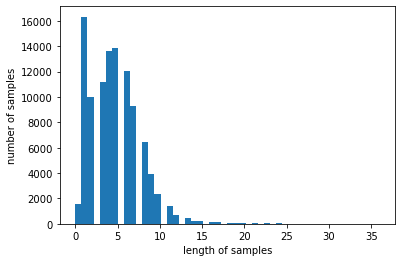

In [253]:
%matplotlib inline
import matplotlib.pyplot as plt

X_data = sequences
print('문장의 최대 길이 : %d' % max(len(l) for l in X_data))
print('문장의 평균 길이 : %f' % (sum(map(len, X_data))/len(X_data)))
plt.hist([len(s) for s in X_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [254]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
# 25보다 길이가 짧은 문장은 전부 숫자 0이 패딩되어 25 길이를 가지게 됨

max_len = 25
# 전체 데이터셋의 길이는 max_len으로 맞춥니다.
data = pad_sequences(X_data, maxlen = max_len)
print("훈련 데이터의 크기(shape): ", data.shape)

훈련 데이터의 크기(shape):  (104273, 25)


In [255]:
# train, test 분리
import numpy as np

X_train = data[:total]
y_train = np.array(y_train_data)
X_test = data[total:]
y_test = np.array(y_test_data)

print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

98152
98152
6121
6121


### 모델(LSTM으로 분류)

In [256]:
from tensorflow.keras.datasets import reuters
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

In [257]:
X_train = pad_sequences(X_train, maxlen=max_len) # 훈련용 데이터(문장) 패딩
X_test = pad_sequences(X_test, maxlen=max_len) # 테스트용 데이터(문장) 패딩

In [258]:
y_train = to_categorical(y_train) # 훈련용 데이터(문장) 레이블의 원-핫 인코딩
y_test = to_categorical(y_test) # 테스트용 데이터(문장) 레이블의 원-핫 인코딩

#### 몇차원으로 해야할지 고민

In [259]:
model = Sequential()
model.add(Embedding(vocab_size, 200)) #120의 차원을 가지는 임베딩 벡터 31242개 생성
model.add(LSTM(120))
model.add(Dense(7, activation='softmax')) #7개로 분류, 소프트맥스-7개의 확률분포 만듦

In [260]:
# 검증 데이터 손실(val_loss)이 증가(과적합 징후) - 검증 데이터 손실이 4회 증가하면 학습을 조기 종료(Early Stopping)
# ModelCheckpoint를 사용하여 검증 데이터의 정확도(val_acc)가 이전보다 좋아질 경우에만 모델을 저장

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [261]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# compile the model
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc',f1_m,precision_m, recall_m])

# fit the model
# history = model.fit(Xtrain, ytrain, validation_split=0.3, epochs=10, verbose=0)

# evaluate the model
# loss, accuracy, f1_score, precision, recall = model.evaluate(Xtest, ytest, verbose=0)

In [262]:
# 다중분류 - categorical_crossentropy 사용

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc',f1_m,precision_m, recall_m])

In [263]:
history = model.fit(X_train, y_train, batch_size=128, epochs=30, callbacks=[es, mc], validation_data=(X_test, y_test))

Epoch 1/30
767/767 [==============================] - 162s 206ms/step - loss: 0.6060 - acc: 0.7972 - f1_m: 0.7649 - precision_m: 0.8547 - recall_m: 0.7196 - val_loss: 0.5461 - val_acc: 0.8352 - val_f1_m: 0.8331 - val_precision_m: 0.8534 - val_recall_m: 0.8142

Epoch 00001: val_acc improved from -inf to 0.83516, saving model to best_model.h5
Epoch 2/30
767/767 [==============================] - 149s 194ms/step - loss: 0.2078 - acc: 0.9345 - f1_m: 0.9345 - precision_m: 0.9442 - recall_m: 0.9251 - val_loss: 0.6190 - val_acc: 0.8322 - val_f1_m: 0.8333 - val_precision_m: 0.8475 - val_recall_m: 0.8197

Epoch 00002: val_acc did not improve from 0.83516
Epoch 3/30
767/767 [==============================] - 146s 190ms/step - loss: 0.1397 - acc: 0.9570 - f1_m: 0.9571 - precision_m: 0.9622 - recall_m: 0.9521 - val_loss: 0.6802 - val_acc: 0.8263 - val_f1_m: 0.8262 - val_precision_m: 0.8359 - val_recall_m: 0.8168

Epoch 00003: val_acc did not improve from 0.83516
Epoch 4/30
767/767 [===============

In [264]:
loaded_model = load_model('best_model.h5', custom_objects={'f1_m': f1_m,'precision_m':precision_m, 'recall_m':recall_m})
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

192/192 [==============================] - 6s 25ms/step - loss: 0.5461 - acc: 0.8352 - f1_m: 0.8334 - precision_m: 0.8542 - recall_m: 0.8145

 테스트 정확도: 0.8352


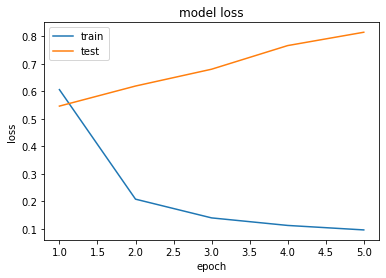

In [265]:
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()